# About
Purpose: Clean up EEG data from MOABB open dataset (Aristimunha et. al, 2023) using a mix of in-built functions from the MNE library (Larson et. al, 2024) and an in-house implementation of methods (e.g. PCA) from basic Python functions (eigenvalues, eigenvectors, covariance matrix). Then, compare it with the in-built ICA from the MNE library.

Code overview:
1. Grab Brain Invaders P300 paradigm (BI2013a) dataset from MOABB and explore its structure
2. Filter using MNE bandpass or bandstop methods.
3. Use PCA to filter eyeblinks
4. Compare with ICA (from MNE) to filter eyeblinks
5. Short Discussion

Terms:
1. **Event-Related Potential (ERP)**: ERPs (e.g. P300) are a category of relatively robust and commonly studied features of an EEG reading in humans that occur after an event. 
2. **P300**: an ERP with a high amplitude positive inflection occuring about 300ms from the event. One robust way to reproduce is to break a pattern (e.g. 111211 will evoke a P300 from the stimulus "2"), which is what is done in Brain Invaders P300 paradigm. (note: identifying them is a nontrivial task because they co-occur with other ERPs,)
3. **MOABB**: Mother of all BCI Benchmarks (MOABB) open dataset for lots of human neurophysiological data (https://github.com/NeuroTechX/moabb)
4. **MNE**: Magnetoencephalography aNd Electroencephalography (MNE)  popular open-source Python package for exploring, visualizing, and analyzing human neurophysiological data (MEG, EEG, etc.) (https://github.com/mne-tools/mne-python)


Sources:
- Aristimunha, B., Carrara, I., Guetschel, P., Sedlar, S., Rodrigues, P., Sosulski, J., Narayanan, D., Bjareholt, E., Quentin, B., Schirrmeister, R. T.,Kalunga, E., Darmet, L., Gregoire, C., Abdul Hussain, A., Gatti, R., Goncharenko, V., Thielen, J., Moreau, T., Roy, Y., Jayaram, V., Barachant,A., & Chevallier, S. Mother of all BCI Benchmarks (MOABB), 2023. DOI: 10.5281/zenodo.10034223.

- Larson, E., Gramfort, A., Engemann, D. A., Leppakangas, J., Brodbeck, C., Jas, M., Brooks, T., Sassenhagen, J., Luessi, M., McCloy, D., King, J.-R., Höchenberger, R., Goj, R., Favelier, G., Brunner, C., van Vliet, M., Wronkiewicz, M., Holdgraf, C., Rockhill, A., … luzpaz. (2024). MNE-Python (v1.6.1). Zenodo. https://doi.org/10.5281/zenodo.10519948

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import moabb.datasets
import mne

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


c:\Users\ddbsu\AppData\Local\Programs\Python\Python310\lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


## 1. Grab Brain Invaders P300 paradigm (BI2013a) dataset from MOABB and explore its structure

Grab data

In [2]:
# Define dataset, the specs of the dataset is not too relevant for this codebase as it is meant to be swappable with any other P300 experiment.
fs = 512
full_dataset = moabb.datasets.BI2013a(
    NonAdaptive=True,
    Adaptive=True,
    Training=True,
    Online=True,
)
subjects_sessions = full_dataset.get_data(subjects=[1]) # Get the first subject only (the full dataset is very large)

Explore its structure

In [3]:
# 1 sessions: 2 runs (Non-Adaptive vs Adaptive) * 2 phases per run (Training + Online) = 4 mne Raw objects per session
# run order randomized 
# ['FP1', 'FP2', 'F5', 'AFz', 'F6', 'T7', 'Cz', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2'] + 1 dimension for events
subjects_sessions[1]['0'] # e.g. All 4 runs from Subject 1, Session 1

# The main sample that we will be exploring with
eeg_mne_raw = subjects_sessions[1]['0']['0'] # MNE Raw object for Subject 1, Session 1, Run 1 
eeg_mne_raw 

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,"16 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


In [4]:
eeg_mne_raw.describe() # Note: ch 16 is the stimulus and is the way MOABB stores experimental conditions {0: no_condition, 1: condition_1, etc.}

<RawArray | 17 x 159232 (311.0 s), ~20.7 MB, data loaded>
ch  name     type  unit        min         Q1     median         Q3        max
 0  Fp1      EEG   µV     28619.28   30337.92   31272.57   32021.51   32603.73
 1  Fp2      EEG   µV     35228.53   37036.60   38952.89   40253.10   40962.55
 2  F5       EEG   µV     21881.29   23732.94   25023.88   25640.42   26507.21
 3  AFz      EEG   µV     25818.69   27472.91   28339.15   29077.39   29811.68
 4  F6       EEG   µV     26899.48   28411.34   29407.17   29927.85   30366.09
 5  T7       EEG   µV     31887.12   33810.55   34817.54   35505.28   36180.83
 6  Cz       EEG   µV     27054.87   28775.14   29825.38   30618.28   31109.32
 7  T8       EEG   µV     27494.59   29289.75   30266.25   31139.62   31730.45
 8  P7       EEG   µV     30458.18   32077.59   32957.64   33539.20   34049.96
 9  P3       EEG   µV     22793.49   24517.90   25646.14   26667.56   27389.31
10  Pz       EEG   µV     29100.43   30478.80   31368.29   31919.62   323

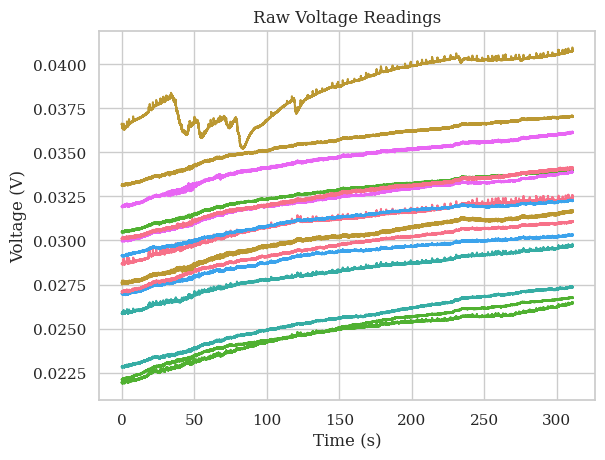

In [5]:
# Plot raw voltage readings from 1 trial the sample (all 16 channels)
# Typically noiseless eeg human data is not >0.001V so we know there is no filtering from MOABB by default. 
all_eeg_channels =  eeg_mne_raw.get_data(picks='eeg') 
all_eeg_channels.shape # (16, 159232): 159232 frames = 311s * 512Hz
for i in np.arange(all_eeg_channels.shape[0] - 1):
    plt.plot(eeg_mne_raw.times, all_eeg_channels[i])
    plt.title("Raw Voltage Readings")
    plt.ylabel("Voltage (V)")  
    plt.xlabel("Time (s)")

Power Spectra Plot

Effective window size : 4.000 (s)


c:\Users\ddbsu\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


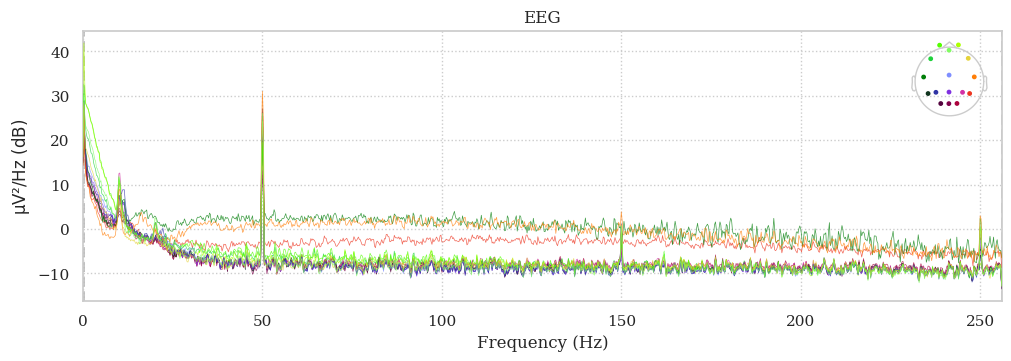

In [6]:
# Power Spectrum of all the channels
    # (note: the mne library has a problem with the matlab backend where their plot() functions outputs 2 plots instead of 1. 
    # adding a semicolon is the official temporary fix)
eeg_mne_raw.compute_psd().plot();

# We can clearly see the power supply noise at 50hz and its 3rd and 5th harmonic, so let's also remove that
# Additionally, high voltage of the recording above is due to DC bias / DC offset, so let's also remove that

## 2. Filter using MNE bandpass or bandstop methods.

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


c:\Users\ddbsu\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\ddbsu\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


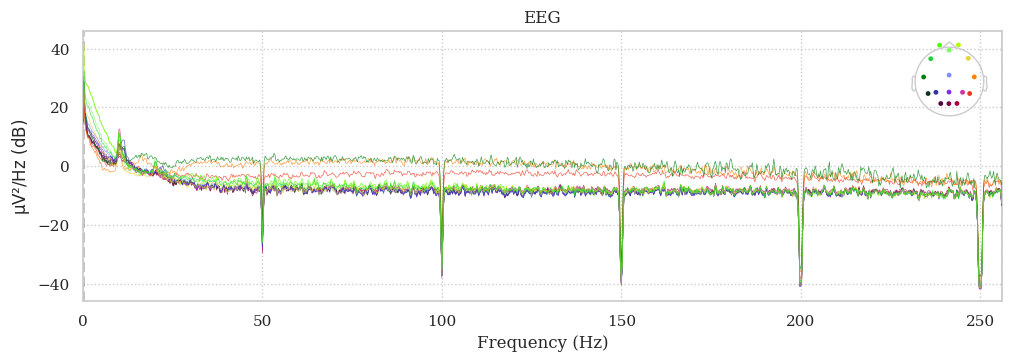

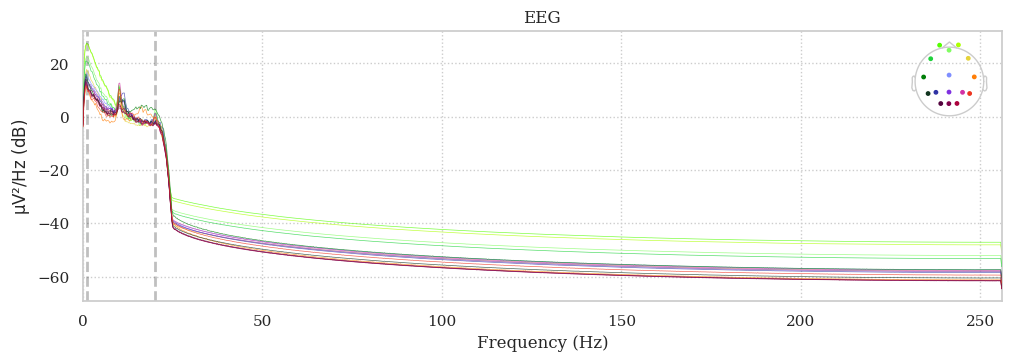

In [7]:
# Remove power supply noise
bye_linefrequency = eeg_mne_raw.copy().notch_filter(np.arange(50,251,50), verbose = False)
bye_linefrequency.compute_psd().plot()
# Remove dc bias noise
alsobye_dcbias = bye_linefrequency.copy().filter(1,20, verbose = False)
alsobye_dcbias.compute_psd().plot();

Text(0.5, 0, 'Time (s)')

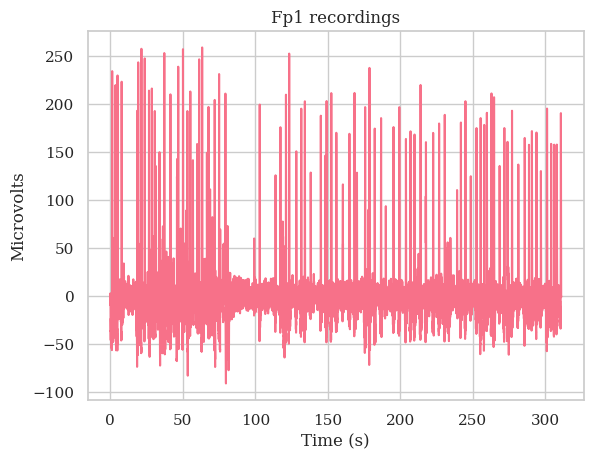

In [8]:
# Plot raw voltage readings from 1 trial (only 1st channel, Fp1, they all look close together now)
all_eeg_channels =  alsobye_dcbias.get_data(picks='eeg') 
i = 1
plt.plot(alsobye_dcbias.times, all_eeg_channels[i] * 1000000)
plt.title("Fp1 recordings")
plt.ylabel("Microvolts")  
plt.xlabel("Time (s)")

# The data looks better but there are a lot of points >100 microvolts which is probably not brain activity
# Eyeblinks are basically any voltage readings >50 microvolts. Many are prominent in the electrodes near the eyes (Fp1, Fp2, etc.)
# Muscle activity is harder to detect, so we will remove eyeblinks and ignore muscle activity for now

## 3. Use PCA to filter eyeblinks

To remove eyeblinks from data, I decided to use following approach:

3a. Find out what an eyeblink wave looks like

3b. Do PCA on eyeblink wave

3c. Project original data onto the subspace spanned by the remaining principal components of the eyeblink wave

The idea behind it is that step 2 will find the dimensions representing noise and step 3 will project the data onto a "noiseless" subspace.

### 3a. Epoching eye blinks (PCA)

C:\Users\ddbsu\AppData\Local\Temp\ipykernel_7448\1481863536.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eyeblink_wave = blink_epochs.get_data()[:,1:3,:] # Both (101,513) epoch arrays of Fp1 and Fp2 combined into (202, 513)
c:\Users\ddbsu\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ddbsu\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


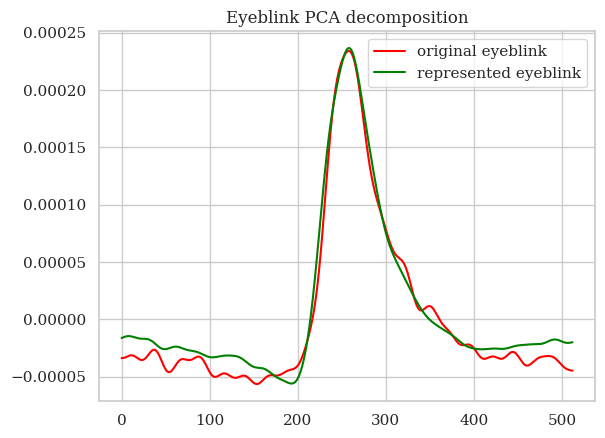

In [9]:
# 1. Finding what an eyeblink wave looks like based on electrodes that are near the eyes [Fp1, Fp2]
    # Uses threshold values based on MNE internal implementation
blink_epochs = mne.preprocessing.create_eog_epochs(alsobye_dcbias, ch_name=['Fp1', 'Fp2'], verbose = False)
# blink_epochs.plot_image(combine="mean") # plot of eyeblink epochs if curious

eyeblink_wave = blink_epochs.get_data()[:,1:3,:] # Both (101,513) epoch arrays of Fp1 and Fp2 combined into (202, 513)
eyeblink_wave = eyeblink_wave.reshape(-1, eyeblink_wave.shape[-1])

# 2. Do PCA on eyeblink wave
# 2a. Eigenvalues of covariance matrix
cov_matrix = np.cov(eyeblink_wave, rowvar=False) # Covariance matrix with columns as variable
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# 2b. Choose the top k eigenvectors (principal components)
k = 2  # Number of principal components to keep
principal_components = eigenvectors[:, :k]

# 2c. Project the original data onto the PC subspace
og = eyeblink_wave[0] #choose the first eyeblink epoch arbitrarily
proj_data = 0
for i in np.arange(principal_components.shape[1]):
    vec = principal_components[:,i]
    proj_matrix = np.outer(vec,vec)
    proj_data += np.matmul(og,proj_matrix)

plt.plot(og, color = 'r', label='original eyeblink')
plt.plot(proj_data, color = 'g', label='represented eyeblink')
plt.title('Eyeblink PCA decomposition')
plt.legend()

To project the original data to the new subspace, it needs to be compatible and the right dataset. i.e. we have to epoch the data and find the target-related potentials.

### 3b. Epoching P300 waves

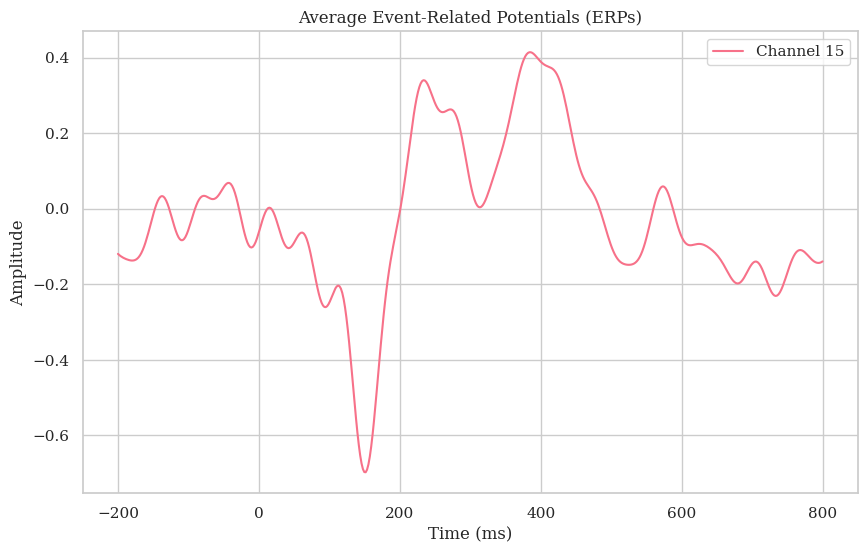

In [10]:
# 1. Create epoch windows eeg waves around target with window [-0.2, 0.8]
epoch_start = -200  # milliseconds before the event
epoch_end = 800    # milliseconds after the event
# Convert epoch boundaries to sample indices
start_index = int(epoch_start * 0.001 * fs)  # 512 Hz sampling rate
end_index = int(epoch_end * 0.001 * fs + 1)

# 2. Extract ERP epochs around each event (80 events per run)
all_eeg_channels = alsobye_dcbias.get_data(picks='eeg')
events = alsobye_dcbias.get_data(picks='stim')[0]
event_indices = np.where(events == 33285)[0] #33285 is id for Target (expected P300) event in the dataset 
erp_epochs = [all_eeg_channels[:, i + start_index:(i + end_index + 1)] for i in event_indices]

# 3. Make the data easier to interpret 
# Standardize each channel independently
erp_epochs_standardized = [(epoch - np.mean(epoch)) / np.std(epoch) for epoch in erp_epochs]
# Average across epochs to obtain ERP
erp_standardized = np.mean(erp_epochs_standardized, axis=0)

# 4. Plot the average ERP waveforms of 1 channel
time_points = np.linspace(epoch_start,epoch_end, erp_standardized.shape[1])
plt.figure(figsize=(10, 6))
channel = 14
plt.plot(time_points, erp_standardized[channel], label=f'Channel {channel + 1}')
plt.title('Average Event-Related Potentials (ERPs)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### 3c. Project onto noiseless dimension

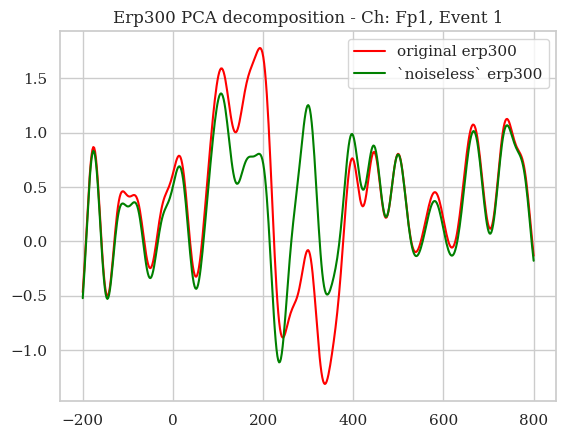

In [11]:
# Project the P300 epochs onto eyeblink PCA null space(?) as it is where there is no noise
everythingbut_principal_components = eigenvectors[:, k:]
og = erp_epochs_standardized[0][0] # [epoch index][channel index]. the first epoch and first channel arbitrarily
# Note: see a big change in the plot (as expected) because the first 2 channels (Fp1, Fp2) are closest to the eyes

proj_data = 0
for i in np.arange(everythingbut_principal_components.shape[1]):
    vec = everythingbut_principal_components[:,i]
    proj_matrix = np.outer(vec,vec)
    proj_data += np.matmul(og,proj_matrix)

plt.plot(time_points, og, color = 'r', label='original erp300')
plt.plot(time_points, proj_data, color = 'g', label='`noiseless` erp300')
plt.title('Erp300 PCA decomposition - Ch: Fp1, Event 1')
plt.legend()

## 4. Compare with ICA (from MNE) to filter eyeblinks

Steps:

4a. Do ICA decomposition on filtered data and exclude eyeblink component

4b. Epoch P300 waves from ICA filtered data

4c. Compare P300 waves from ICA filtered data and P300 waves from original data.

### 4a. Do ICA decomposition on filtered data and exclude eyeblink component

Fitting ICA to data using 16 channels (please be patient, this may take a while)


Selecting by number: 3 components
Fitting ICA took 0.3s.
Creating RawArray with float64 data, n_channels=3, n_times=159232
    Range : 0 ... 159231 =      0.000 ...   310.998 secs
Ready.
Using matplotlib as 2D backend.


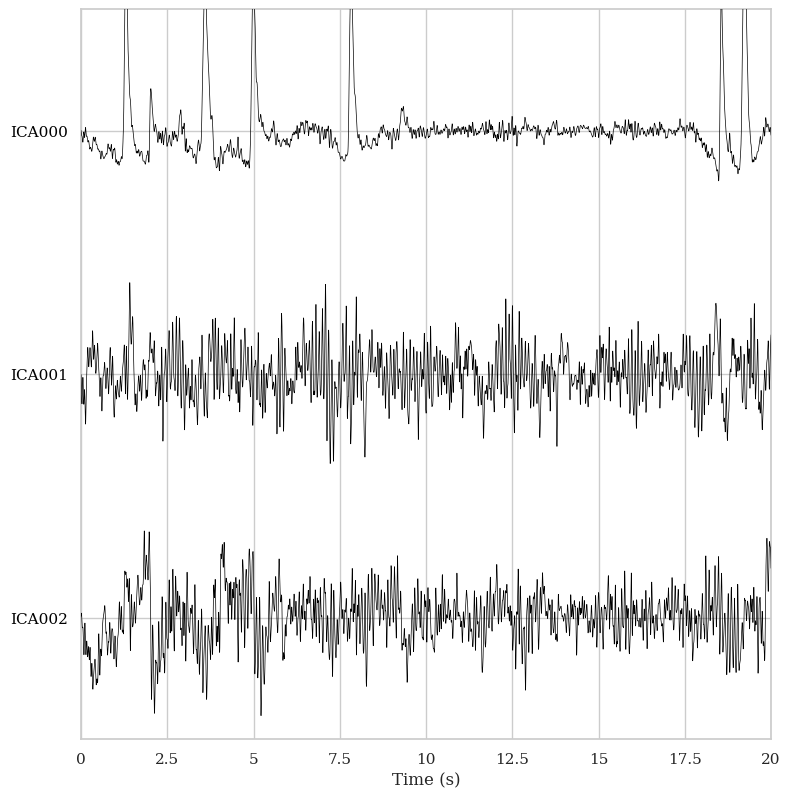

In [12]:
# ICA is like PCA but finds uncorrelated vectors. We use the internal implementation by MNE.
from mne.preprocessing import ICA

# Choose 2 independent sources of the signal
ica = ICA(n_components=3, max_iter="auto", random_state=97)
ica.fit(alsobye_dcbias)
ica.plot_sources(alsobye_dcbias, show_scrollbars=False);

#ICA000 are eyeblinks most likely, so let's remove that

Applying ICA to Raw instance
    Transforming to ICA space (3 components)
    Zeroing out 1 ICA component
    Projecting back using 16 PCA components


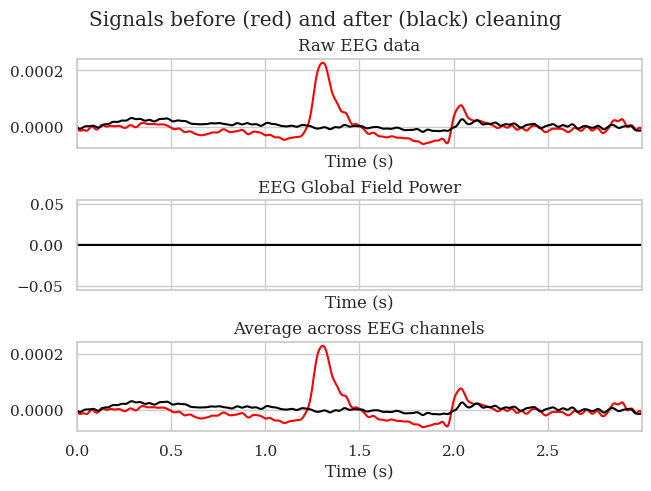

In [13]:
# Remove the ICA000
ica.exclude = [0]
ica_filtered_data = alsobye_dcbias.copy()
ica.apply(ica_filtered_data)
# See its effect on Fp1, the first channel
ica.plot_overlay(alsobye_dcbias, exclude=[0], picks=['Fp1'], verbose = False);

### 4b. Epoch P300 waves from ICA filtered data

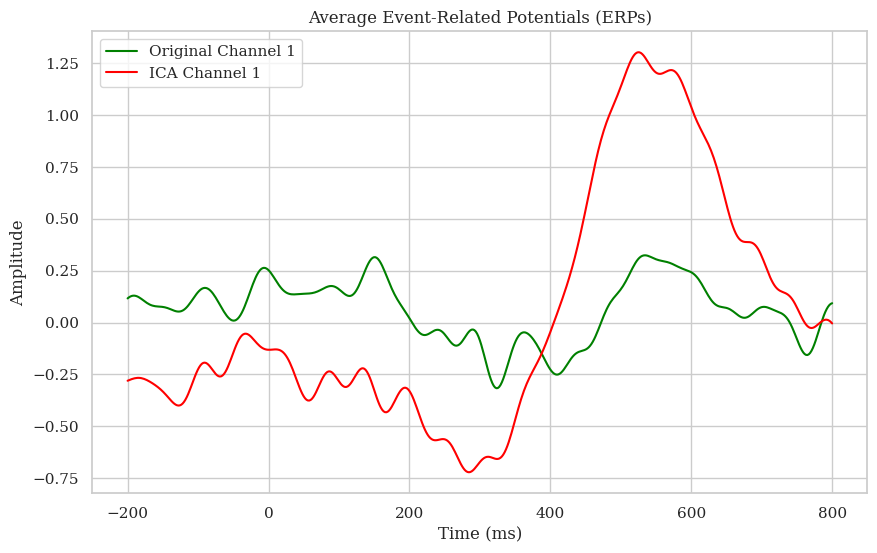

In [14]:
# 1. Epoch eeg waves around target with window [-0.2, 0.8]
epoch_start = -200  # milliseconds before the event
epoch_end = 800    # milliseconds after the event
# Convert epoch boundaries to sample indices
start_index = int(epoch_start * 0.001 * fs)  # 512 Hz sampling rate
end_index = int(epoch_end * 0.001 * fs + 1)

# 2. Extract ERP epochs around each event (still 80 events per run so no rejections due to filtering)
ica_all_eeg_channels = ica_filtered_data.get_data(picks='eeg')
ica_events = ica_filtered_data.get_data(picks='stim')[0]
ica_event_indices = np.where(ica_events == 33285)[0] #33285 is id for Target (expected P300) event in the dataset 
ica_erp_epochs = [ica_all_eeg_channels[:, i + start_index:(i + end_index + 1)] for i in ica_event_indices]

# 3. Make the data easier to interpret 
# Standardize each channel independently
ica_erp_epochs_standardized = [(epoch - np.mean(epoch)) / np.std(epoch) for epoch in ica_erp_epochs]
# Average across epochs to obtain ERP
ica_erp_standardized = np.mean(ica_erp_epochs_standardized, axis=0)

# 4. Plot the ERP waveforms of 1 channel
time_points = np.linspace(epoch_start,epoch_end, ica_erp_standardized.shape[1])
plt.figure(figsize=(10, 6))
channel = 0
plt.plot(time_points, ica_erp_standardized[channel], label=f'Original Channel {channel + 1}', color = 'g')
plt.plot(time_points, erp_standardized[channel], label=f'ICA Channel {channel + 1}', color = 'r')
plt.title('Average Event-Related Potentials (ERPs)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

We verify that the raw voltage readings from 1 trial (only 1st channel, Fp1) no longer have readings more than 50 microvolts. Thus, filtering eyeblinks was succesful.

Note: this could not be done with PCA because PCA was done after epoching. Here, ICA was done before epoching.  

Text(0.5, 0, 'Time (s)')

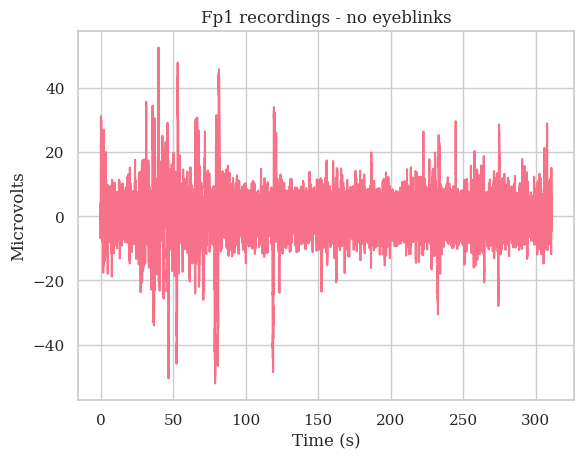

In [15]:
# Plot raw voltage readings from 1 trial (only 1st channel, Fp1)
plt.plot(ica_filtered_data.times, ica_all_eeg_channels[0] * 1000000)
plt.title("Fp1 recordings - no eyeblinks")
plt.ylabel("Microvolts")  
plt.xlabel("Time (s)")

### 4c. Compare P300 waves from ICA filtered data and P300 waves from original data.

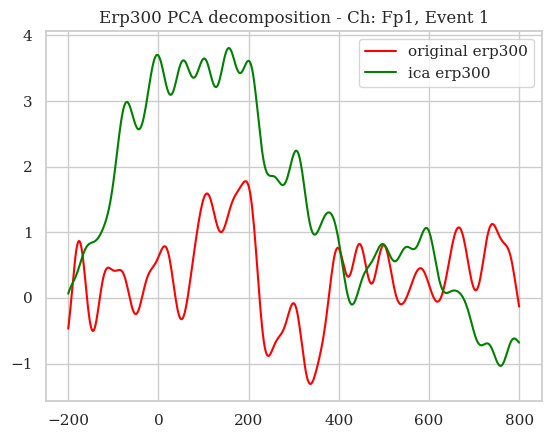

In [16]:
og = erp_epochs_standardized[0][0]
og_ica = ica_erp_epochs_standardized[0][0] # [epoch index][channel index]. the first epoch and first channel arbitrarily
# Note: see a big change in the plot (as expected) because the first 2 channels are closest to the eyes
plt.plot(time_points, og, color = 'r', label='original erp300')
plt.plot(time_points, og_ica, color = 'g', label='ica erp300')
plt.title('Erp300 PCA decomposition - Ch: Fp1, Event 1')
plt.legend()

# 5. Discussion

The results of the PCA filtering that I implemented (4c - green) did not have the same effect on the original data as the ICA filtering by MNE (5c - green). I'm not sure why this is the case. I think it is potentially a result of the different order that I did the analysis where 
- PCA: raw -> eyeblink epochs -> PCA
- ICA: raw -> ICA -> epoch

Thus, ICA could reasonably capture more of the noise due to a longer window. However, I think my method of projecting data onto the null space of the noise components may be theoretically incorrect. Further criticism is necessary. 